In [60]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler

### Generate the problem / prepare selected datasets

In [2]:
nrows = 10000

In [3]:
numerical_features_index = [0, 2, 4, 10, 11, 12]

data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
y_train = data_train.loc[:, data_train.columns[-1]]
gender_train = data_train.loc[:, data_train.columns[9]]


data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
y_test = data_test.loc[:, data_train.columns[-1]]
gender_test = data_test.loc[:, data_test.columns[9]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_test.drop(data_test.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)
data_test = data_test.astype(np.float64)



gender_train = gender_train.apply(lambda x: x.strip())
gender_test = gender_test.apply(lambda x: x.strip())

In [4]:
data_train.shape

(10000, 6)

In [5]:
data_train.drop_duplicates(inplace=True)
y_train = y_train.loc[data_train.index]
gender_train = gender_train.loc[data_train.index]

assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]

In [6]:
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.fit_transform(y_test).ravel()

In [7]:
gender_binarizer = LabelBinarizer()
gender_binary = gender_binarizer.fit_transform(gender_test.values).ravel()

In [8]:
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [10]:
clf_base = RandomForestClassifier(n_estimators=100)

In [11]:
clf = clone(clf_base)

clf.fit(data_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
print('Initial accuracy of classification: {}'.format(accuracy_score(y_test, clf.predict(data_test))))

Initial accuracy of classification: 0.8103310607456544


In [13]:
male_entries_index = gender_train[gender_train == 'Male'].index
female_entries_index = gender_train[gender_train == 'Female'].index

male_entries_test_index = gender_test[gender_test == 'Male'].index
female_entries_test_index = gender_test[gender_test == 'Female'].index

In [14]:
n0 = data_train[gender_train == 'Male'].shape[0]
n1 = data_train[gender_train == 'Female'].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0

emperical_histogram_female = np.ones_like(female_entries_index) / n1

In [15]:
C = ot.dist(data_train[gender_train == 'Male'], data_train[gender_train == 'Female'])

In [65]:
coupling = ot.sinkhorn(emperical_histogram_male, emperical_histogram_female, C, reg=1e-4, numItermax=10000000)

/home/grapefroot/datascience3/lib/python3.6/site-packages/ot/bregman.py:370: RuntimeWarning: divide by zero encountered in true_divide
  v = np.divide(b, KtransposeU)
/home/grapefroot/datascience3/lib/python3.6/site-packages/ot/bregman.py:370: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


In [66]:
coupling1 = ot.emd(emperical_histogram_male, emperical_histogram_female, C, numItermax=1000000000)

In [67]:
def confusion_matrix(predictions, protected_attribute):
    n = predictions.shape[0]
    a = np.sum((predictions == 0) & (protected_attribute == 0)) / n
    b = np.sum((predictions == 1) & (protected_attribute == 0)) / n
    c = np.sum((predictions == 0) & (protected_attribute == 1)) / n
    d = np.sum((predictions == 1) & (protected_attribute == 1)) / n
    return a, b, c, d
      
def balanced_error_rate(y_true, y_pred, protected_attributes):
    pass

In [68]:
def likelihood_ratio(y_predicted, protected):
    #following https://arxiv.org/pdf/1412.3756.pdf
    a, b, c, d = confusion_matrix(y_predicted, protected)
    return d * (a + c) / c / (b + d)

In [69]:
def disparate_impact(y_true, protected):
    return 1. / likelihood_ratio(y_true, protected)

In [70]:
def construct_map(weights, data_first, data_second, coupling):
    weight_1, weight_2 = weights
    print(weights)
    n0 = data_train[gender_train == 'Male'].shape[0]
    n1 = data_train[gender_train == 'Female'].shape[0]
    mapped_class_0 = weight_1 * data_first  + n0 * weight_2 * (coupling @ data_second)
    mapped_class_1 = weight_1 * n1 * (coupling.T @ data_first) + weight_2 * data_second
    return mapped_class_0, mapped_class_1

In [71]:
def transform_dataset(weights, data_first, data_second, y, coupling):
    mapped_class_0, mapped_class_1 = construct_map(weights, data_first, data_second, coupling)
    y_mapped_0 = y[gender_train == 'Male']
    y_mapped_1 = y[gender_train == 'Female']
    return np.concatenate((mapped_class_0, mapped_class_1)), np.concatenate((y_mapped_0, y_mapped_1))

In [72]:
from tqdm import tqdm_notebook

In [73]:
print('class 0 size {}'.format(data_train[gender_train == 'Female'].shape))
print('class 1 size {}'.format(data_train[gender_train == 'Male'].shape))

class 0 size (3292, 6)
class 1 size (6682, 6)


In [75]:
acs_1 = []
dims_1 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=100)):
    X_new, y_new = transform_dataset([repair_value, 1-repair_value], data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_train, coupling1)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    print(repair_value)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs.append(accuracy_sc)
    dims.append(disparate_im)
    print('Accuracy score {}'.format(accuracy_sc))
    print('Disparate impact {}'.format(disparate_im))

[0.0, 1.0]
0.0
Accuracy score 0.7973711688471224
Disparate impact 0.8690769660180513
[0.010101010101010102, 0.98989898989899]
0.010101010101010102
Accuracy score 0.7898163503470302
Disparate impact 0.8725414539470138
[0.020202020202020204, 0.9797979797979798]
0.020202020202020204
Accuracy score 0.7890792948836066
Disparate impact 0.8792422250660907
[0.030303030303030304, 0.9696969696969697]
0.030303030303030304
Accuracy score 0.7878508691112339
Disparate impact 0.8759694068567148
[0.04040404040404041, 0.9595959595959596]
0.04040404040404041
Accuracy score 0.7895706651925557
Disparate impact 0.8746248662628803
[0.05050505050505051, 0.9494949494949495]
0.05050505050505051
Accuracy score 0.7880965542657085
Disparate impact 0.8768646403754881
[0.06060606060606061, 0.9393939393939394]
0.06060606060606061
Accuracy score 0.7870523923591917
Disparate impact 0.8845396448774497
[0.07070707070707072, 0.9292929292929293]
0.07070707070707072
Accuracy score 0.7919046741600638
Disparate impact 0.8757

0.6363636363636365
Accuracy score 0.8011178674528592
Disparate impact 0.8563623651276377
[0.6464646464646465, 0.3535353535353535]
0.6464646464646465
Accuracy score 0.8011792887414778
Disparate impact 0.8522939138460802
[0.6565656565656566, 0.3434343434343434]
0.6565656565656566
Accuracy score 0.8005650758552915
Disparate impact 0.8525718772838239
[0.6666666666666667, 0.33333333333333326]
0.6666666666666667
Accuracy score 0.8007493397211474
Disparate impact 0.8479898103002373
[0.6767676767676768, 0.3232323232323232]
0.6767676767676768
Accuracy score 0.80332903384313
Disparate impact 0.8469355006331629
[0.686868686868687, 0.31313131313131304]
0.686868686868687
Accuracy score 0.804004668017935
Disparate impact 0.843077359533337
[0.696969696969697, 0.303030303030303]
0.696969696969697
Accuracy score 0.807198575026104
Disparate impact 0.8462210393259795
[0.7070707070707072, 0.2929292929292928]
0.7070707070707072
Accuracy score 0.807198575026104
Disparate impact 0.8461181896297092
[0.7171717

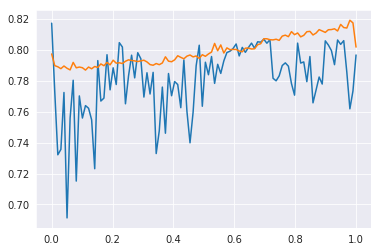

In [77]:
with sns.axes_style('darkgrid'):
    plt.plot(np.linspace(0, 1, 100), acs[:100])
    plt.plot(np.linspace(0, 1, 100), acs[100:])

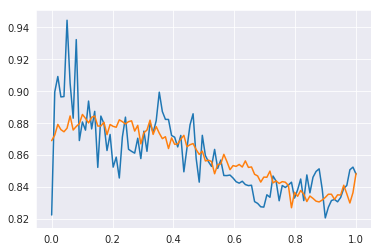

In [78]:
with sns.axes_style('darkgrid'):
    plt.plot(np.linspace(0, 1, 100), dims[:100])
    plt.plot(np.linspace(0, 1, 100), dims[100:])

In [46]:
X_new, y_new = transform_dataset([0.4, 0.6], data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_train, coupling)

[0.4, 0.6]


In [47]:
disparate_impact(clf.predict(data_test), gender_binary)

0.8426804052258893

In [48]:
clf1 = clone(clf_base)
clf1.fit(X_new, y_new)

accuracy_score(y_test, clf1.predict(data_test))

0.794422946993428

In [49]:
disparate_impact(clf1.predict(data_test), gender_binary)

0.8711993647916861

### Show that different solutions for the same transporation problem can have different fairness

### Explore how the regularized barycenters are defined, try to apply them to the problem

### Use the regularized transport maps instead of usual ones